<a href="https://colab.research.google.com/github/shreya7code/CNN_Models_MNSIT/blob/main/deeplearning_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data transform


In [ ]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from torchvision.datasets import ImageFolder
from torchsummary import summary
# from torchvision import datasets, transforms,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Transformation

In [ ]:
# data_dir = '/content/drive/MyDrive/deepLearning/dataset/'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Load MNIST Dataset

In [ ]:
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# ✅ 6. Split train into train + val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]


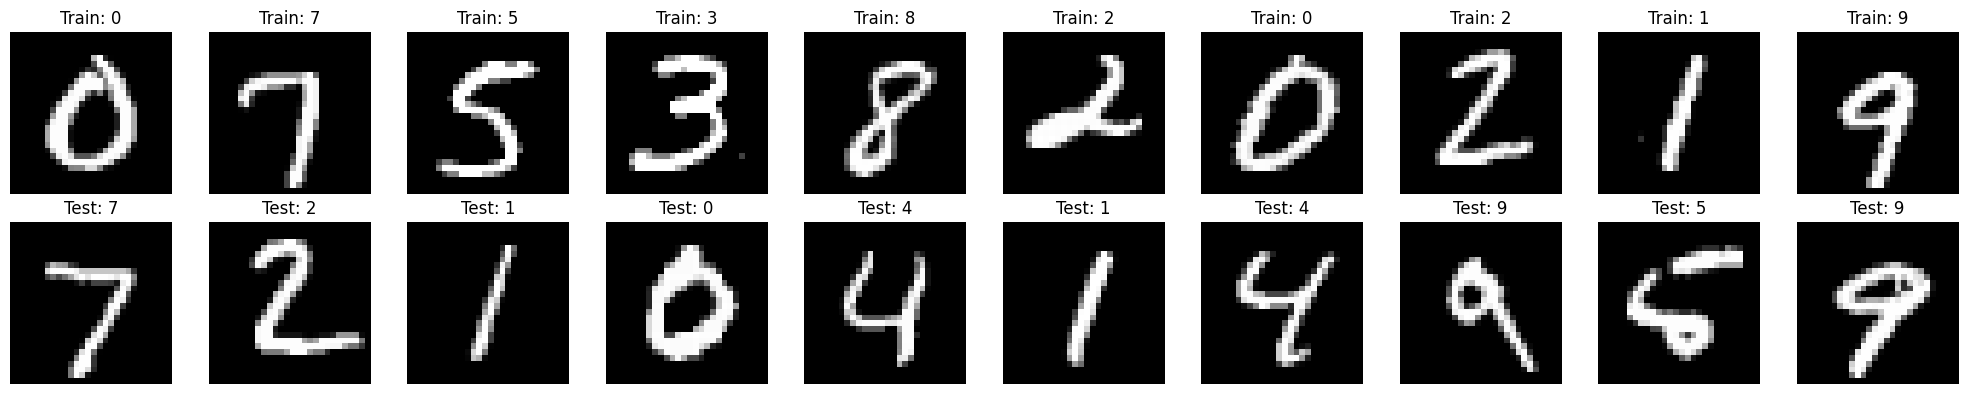

In [ ]:
# View Sample Images from Train and Test Sets
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    train_img, train_lbl = train_dataset[i]
    test_img, test_lbl = test_dataset[i]

    axes[0, i].imshow(train_img.squeeze(), cmap='gray')
    axes[0, i].set_title(f"Train: {train_lbl}")
    axes[0, i].axis('off')

    axes[1, i].imshow(test_img.squeeze(), cmap='gray')
    axes[1, i].set_title(f"Test: {test_lbl}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Defining Model

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Hidden Layer 1
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Hidden Layer 2
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Hidden Layer 3
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Hidden Layer 4
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),                   # Hidden Layer 5
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),                         # Hidden Layer 6
            nn.ReLU(),
            nn.Linear(128, 10)                           # Output Layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


### Train model


In [ ]:
def train_model(model, name):
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
  epochs = 10

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  for epoch in range(epochs):
      model.train()
      train_loss = 0.0
      correct = 0
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          output = model(images)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          preds = torch.argmax(output, dim=1)
          correct += (preds == labels).sum().item()

      train_acc = correct / len(train_loader.dataset)
      train_loss = train_loss / len(train_loader)

      # validation
      model.eval()
      val_loss, val_correct = 0.0, 0
      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              output = model(images)
              val_loss += criterion(output, labels).item()
              preds = torch.argmax(output, dim=1)
              val_correct += (preds == labels).sum().item()

      val_acc = val_correct / len(val_loader.dataset)
      val_loss = val_loss / len(val_loader)

      train_losses.append(train_loss)
      train_accuracies.append(train_acc)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)

      print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
  return model, train_accuracies, val_accuracies, train_losses, val_losses


In [ ]:
scratch_model = MNIST_CNN()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = MNIST_CNN()
# model, train_acc, train_loss, val_acc, val_loss = train_model(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scratch_model.to(device)
summary(scratch_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,928
              ReLU-9           [-1, 64, 14, 14]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Linear-11                  [-1, 256]         803,072
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
scratch_model, s_tr_acc, s_val_acc, s_tr_loss, s_val_loss = train_model(scratch_model, "Scratch")




Epoch 1/10, Train Acc: 0.9227, Val Acc: 0.9787
Epoch 2/10, Train Acc: 0.9802, Val Acc: 0.9861
Epoch 3/10, Train Acc: 0.9860, Val Acc: 0.9863
Epoch 4/10, Train Acc: 0.9887, Val Acc: 0.9861
Epoch 5/10, Train Acc: 0.9905, Val Acc: 0.9887
Epoch 6/10, Train Acc: 0.9921, Val Acc: 0.9896
Epoch 7/10, Train Acc: 0.9930, Val Acc: 0.9892
Epoch 8/10, Train Acc: 0.9937, Val Acc: 0.9913
Epoch 9/10, Train Acc: 0.9940, Val Acc: 0.9912
Epoch 10/10, Train Acc: 0.9955, Val Acc: 0.9912


In [ ]:
def evaluate(model, name):
  model.eval()
  test_preds, test_labels = [], []
  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device)
          outputs = model(images)
          preds = torch.argmax(outputs, dim=1).cpu()
          test_preds.extend(preds.numpy())
          test_labels.extend(labels.numpy())

  print(f"\n{name} Model Evaluation Report")
  print(classification_report(test_labels, test_preds))

  cm = confusion_matrix(test_labels, test_preds)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title(f"{name} Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()





Scratch Model Evaluation Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



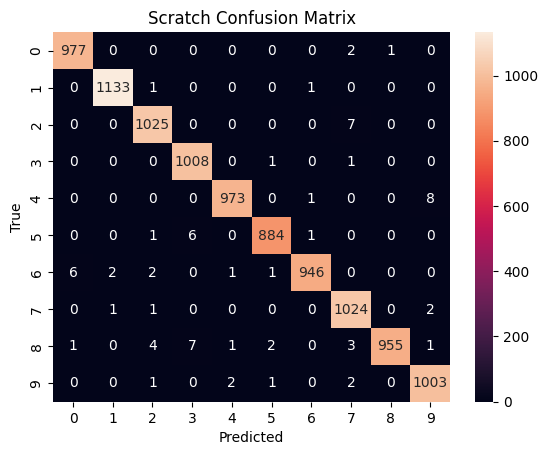

In [ ]:
evaluate(scratch_model, "Scratch")

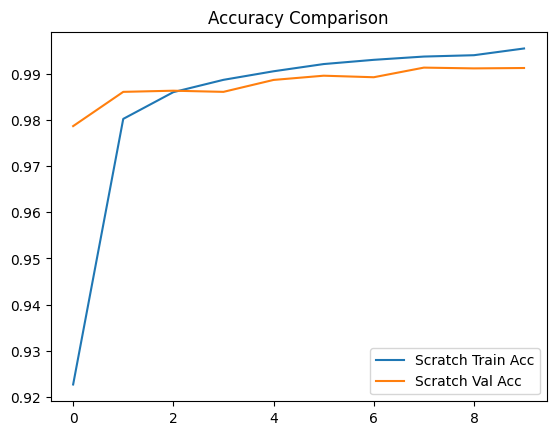

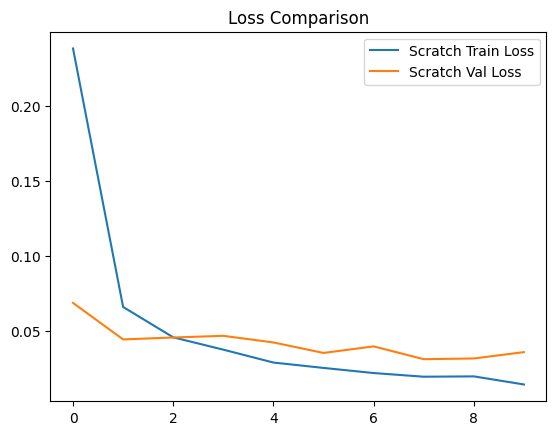

In [ ]:
plt.plot(s_tr_acc, label='Scratch Train Acc')
plt.plot(s_val_acc, label='Scratch Val Acc')
plt.legend()
plt.title("Accuracy Comparison")
plt.show()

plt.plot(s_tr_loss, label='Scratch Train Loss')
plt.plot(s_val_loss, label='Scratch Val Loss')
plt.legend()
plt.title("Loss Comparison")
plt.show()

In [ ]:
model_path_scratch = '/content/drive/MyDrive/DeepLearning/assignment2_mnist_scratch_model.pth'
torch.save(scratch_model.state_dict(), model_path_scratch)
print(f"Model saved to {model_path_scratch}")

Model saved to /content/drive/MyDrive/DeepLearning/assignment2_mnist_scratch_model.pth


Predict the output with test data and custom data

In [ ]:
import random

def predict_test_image(model, test_dataset):
    model.eval()
    idx = random.randint(0, len(test_dataset)-1)
    image, label = test_dataset[idx]
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"True Label: {label}")
    plt.axis("off")
    plt.show()

    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        print(f"Predicted Label: {predicted_class}")



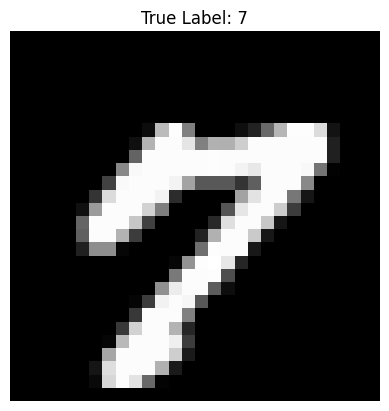

Predicted Label: 7


In [ ]:
predict_test_image(scratch_model, test_dataset)

In [ ]:
from PIL import Image

def predict_custom_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted = torch.argmax(output, dim=1).item()

    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Label: {predicted}")
    plt.axis("off")
    plt.show()

# Example usage:
# predict_custom_image("/content/path_to_your_image.png", model)


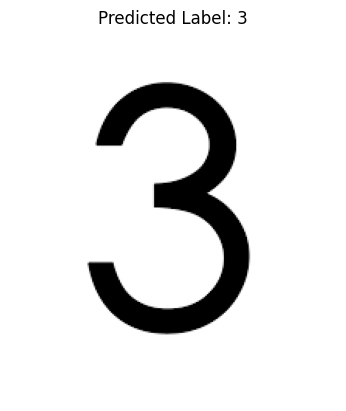

In [ ]:
predict_custom_image(scratch_model, '/content/drive/MyDrive/DeepLearning/test_image_mnist_3.png')

## Pretrained model - ResNet18, AlexNet, DenseNet, and LeNet

ResNet-18

In [ ]:
#Resnet
resnet18_model = models.resnet18(pretrained=True)
resnet18_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet18_model, resnet_tr_acc, resnet_val_acc, resnet_tr_loss, resnet_val_loss = train_model(resnet18_model, "ResNet-18 Pretrained")

Epoch 1/10, Train Acc: 0.9426, Val Acc: 0.9715
Epoch 2/10, Train Acc: 0.9779, Val Acc: 0.9812
Epoch 3/10, Train Acc: 0.9824, Val Acc: 0.9748
Epoch 4/10, Train Acc: 0.9870, Val Acc: 0.9872
Epoch 5/10, Train Acc: 0.9882, Val Acc: 0.9839
Epoch 6/10, Train Acc: 0.9895, Val Acc: 0.9890
Epoch 7/10, Train Acc: 0.9911, Val Acc: 0.9881
Epoch 8/10, Train Acc: 0.9919, Val Acc: 0.9821
Epoch 9/10, Train Acc: 0.9914, Val Acc: 0.9871
Epoch 10/10, Train Acc: 0.9933, Val Acc: 0.9909


In [ ]:
def evaluate_predefined_models(model, model_name):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.4f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


Test Accuracy: 99.2000%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



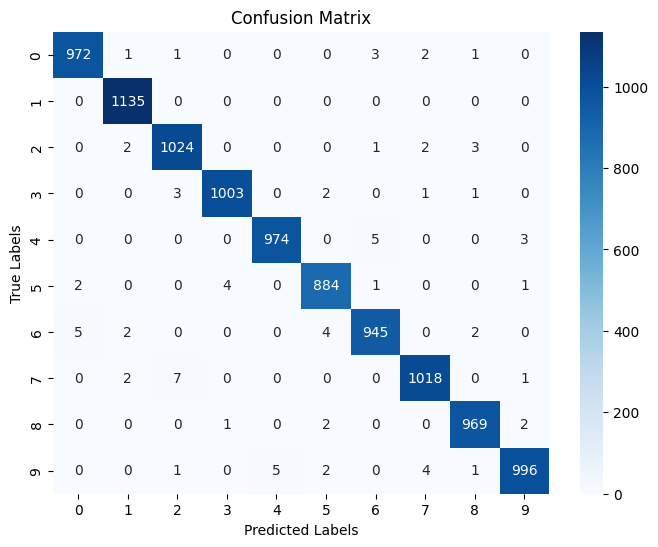

In [ ]:
evaluate_predefined_models(resnet18_model, "ResNet-18")

In [ ]:
model_path_resnet = '/content/drive/MyDrive/DeepLearning/assignment2_mnist_resnet_model.pth'
torch.save(resnet18_model.state_dict(), model_path_resnet)
print(f"Model saved to {model_path_scratch}")

Model saved to /content/drive/MyDrive/DeepLearning/assignment2_mnist_scratch_model.pth


AlexNet

In [ ]:
# alexnet
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
alexnet_model, alexnet_tr_acc, alexnet_val_acc, alexnet_tr_loss, alexnet_val_loss = train_model(resnet18_model, "AlexNet Pretrained")

Epoch 1/10, Train Acc: 0.9932, Val Acc: 0.9871
Epoch 2/10, Train Acc: 0.9930, Val Acc: 0.9823
Epoch 3/10, Train Acc: 0.9945, Val Acc: 0.9898
Epoch 4/10, Train Acc: 0.9947, Val Acc: 0.9920
Epoch 5/10, Train Acc: 0.9965, Val Acc: 0.9898
Epoch 6/10, Train Acc: 0.9959, Val Acc: 0.9909
Epoch 7/10, Train Acc: 0.9952, Val Acc: 0.9884
Epoch 8/10, Train Acc: 0.9963, Val Acc: 0.9904
Epoch 9/10, Train Acc: 0.9966, Val Acc: 0.9888
Epoch 10/10, Train Acc: 0.9969, Val Acc: 0.9892


Test Accuracy: 99.2400%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



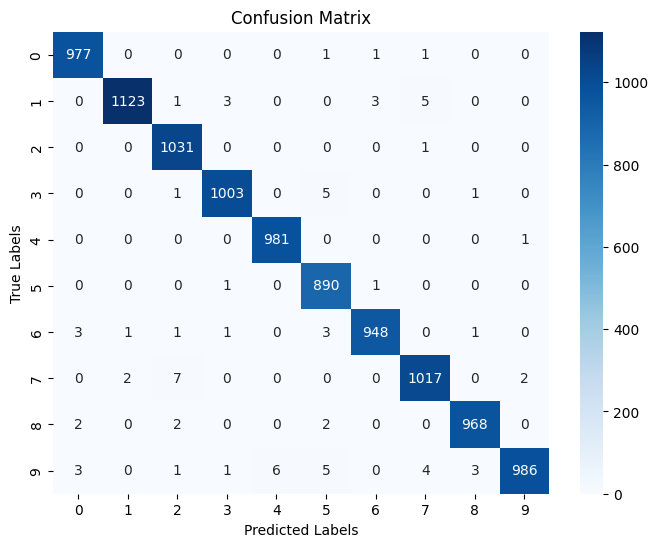

In [ ]:
evaluate_predefined_models(alexnet_model, "AlexNet")

In [ ]:
model_path_alexnet = '/content/drive/MyDrive/DeepLearning/assignment2_mnist_alexnet_model.pth'
torch.save(alexnet_model.state_dict(), model_path_alexnet)
print(f"Model saved to {model_path_alexnet}")

Model saved to /content/drive/MyDrive/DeepLearning/assignment2_mnist_alexnet_model.pth


DenseNet

In [ ]:
# # densenet
# densenet_model = models.densenet121(pretrained=True)

# # Modify the first convolution layer to accept 1-channel input instead of 3
# densenet_model.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 10)

In [ ]:
# densenet_model, densenet_tr_acc, densenet_val_acc, densenet_tr_loss, densenet_val_loss = train_model(densenet_model, "DenseNet Pretrained")

In [ ]:
# evaluate_predefined_models(densenet_model, "DenseNet")

LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),  # Modify this line: 1 input channel (grayscale)
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Initialize the model and print the summary
leNet_model = LeNet()
leNet_model.to(device)
summary(leNet_model, (1, 28, 28))  # (1, 28, 28) for grayscale MNIST images


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              Tanh-2            [-1, 6, 24, 24]               0
         AvgPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              Tanh-5             [-1, 16, 8, 8]               0
         AvgPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              Tanh-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
lenet_model, lenet_tr_acc, lenet_val_acc, lenet_tr_loss, lenet_val_loss = train_model(leNet_model, "LeNet")

Epoch 1/10, Train Acc: 0.9122, Val Acc: 0.9587
Epoch 2/10, Train Acc: 0.9706, Val Acc: 0.9708
Epoch 3/10, Train Acc: 0.9796, Val Acc: 0.9782
Epoch 4/10, Train Acc: 0.9841, Val Acc: 0.9804
Epoch 5/10, Train Acc: 0.9866, Val Acc: 0.9790
Epoch 6/10, Train Acc: 0.9886, Val Acc: 0.9828
Epoch 7/10, Train Acc: 0.9903, Val Acc: 0.9838
Epoch 8/10, Train Acc: 0.9922, Val Acc: 0.9834
Epoch 9/10, Train Acc: 0.9926, Val Acc: 0.9838
Epoch 10/10, Train Acc: 0.9940, Val Acc: 0.9826


Test Accuracy: 98.5800%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



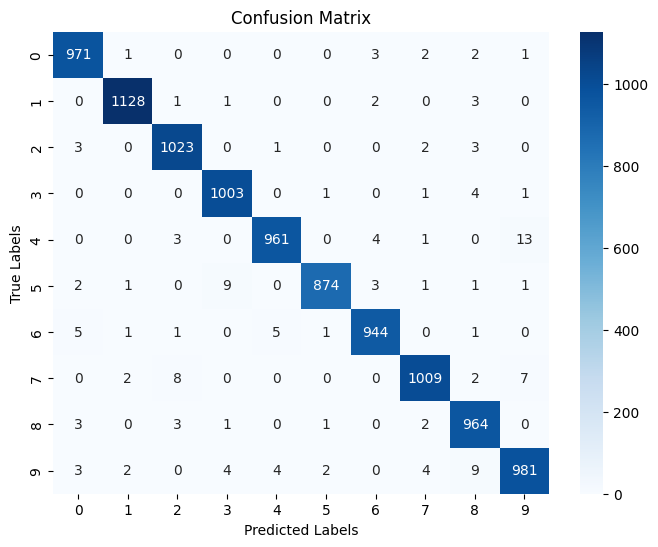

In [ ]:
evaluate_predefined_models(lenet_model, "LeNet")

In [ ]:
model_path_lenet = '/content/drive/MyDrive/DeepLearning/assignment2_mnist_lenet_model.pth'
torch.save(lenet_model.state_dict(), model_path_lenet)
print(f"Model saved to {model_path_lenet}")

Model saved to /content/drive/MyDrive/DeepLearning/assignment2_mnist_lenet_model.pth


### Pre-trained Model Accuracy and Loss Comparision

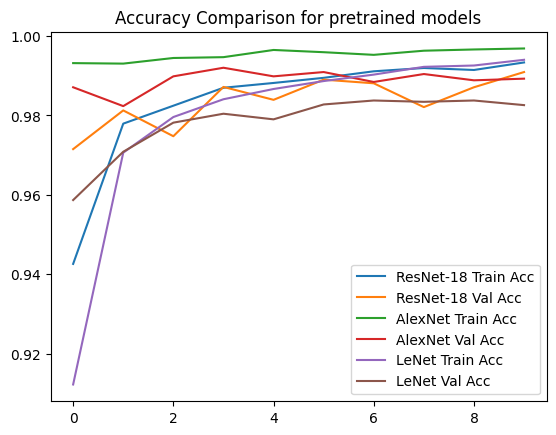

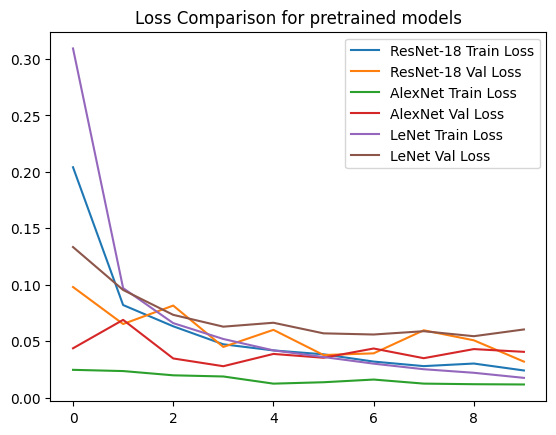

In [ ]:
plt.plot(resnet_tr_acc, label='ResNet-18 Train Acc')
plt.plot(resnet_val_acc, label='ResNet-18 Val Acc')
plt.plot(alexnet_tr_acc, label='AlexNet Train Acc')
plt.plot(alexnet_val_acc, label='AlexNet Val Acc')
plt.plot(lenet_tr_acc, label='LeNet Train Acc')
plt.plot(lenet_val_acc, label='LeNet Val Acc')
plt.legend()
plt.title("Accuracy Comparison for pretrained models")
plt.show()

plt.plot(resnet_tr_loss, label='ResNet-18 Train Loss')
plt.plot(resnet_val_loss, label='ResNet-18 Val Loss')
plt.plot(alexnet_tr_loss, label='AlexNet Train Loss')
plt.plot(alexnet_val_loss, label='AlexNet Val Loss')
plt.plot(lenet_tr_loss, label='LeNet Train Loss')
plt.plot(lenet_val_loss, label='LeNet Val Loss')
plt.legend()
plt.title("Loss Comparison for pretrained models")
plt.show()

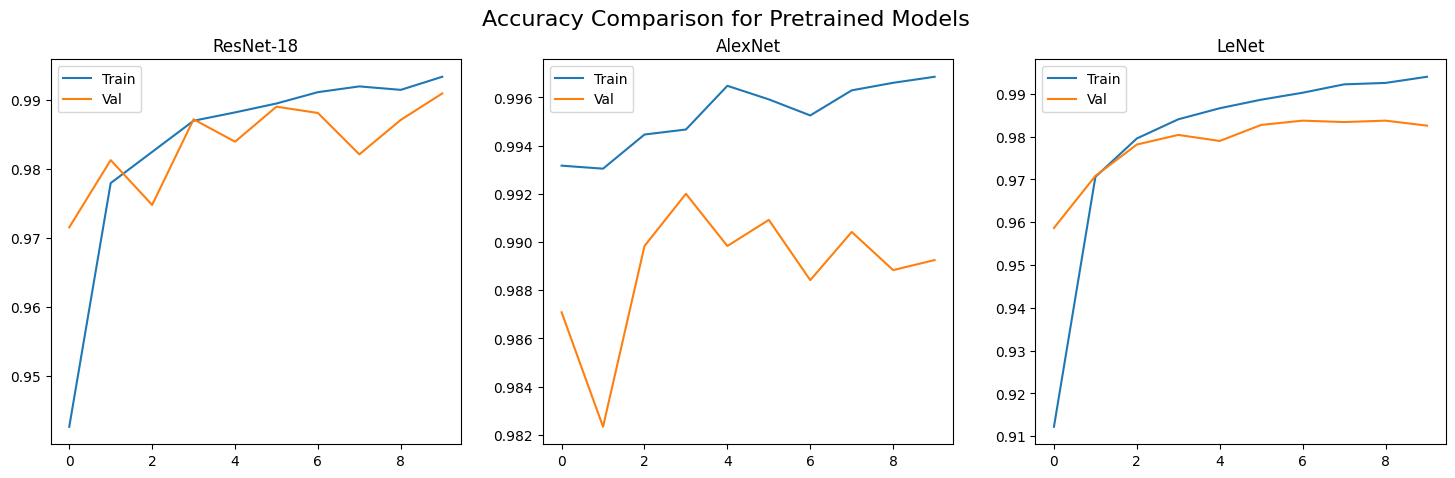

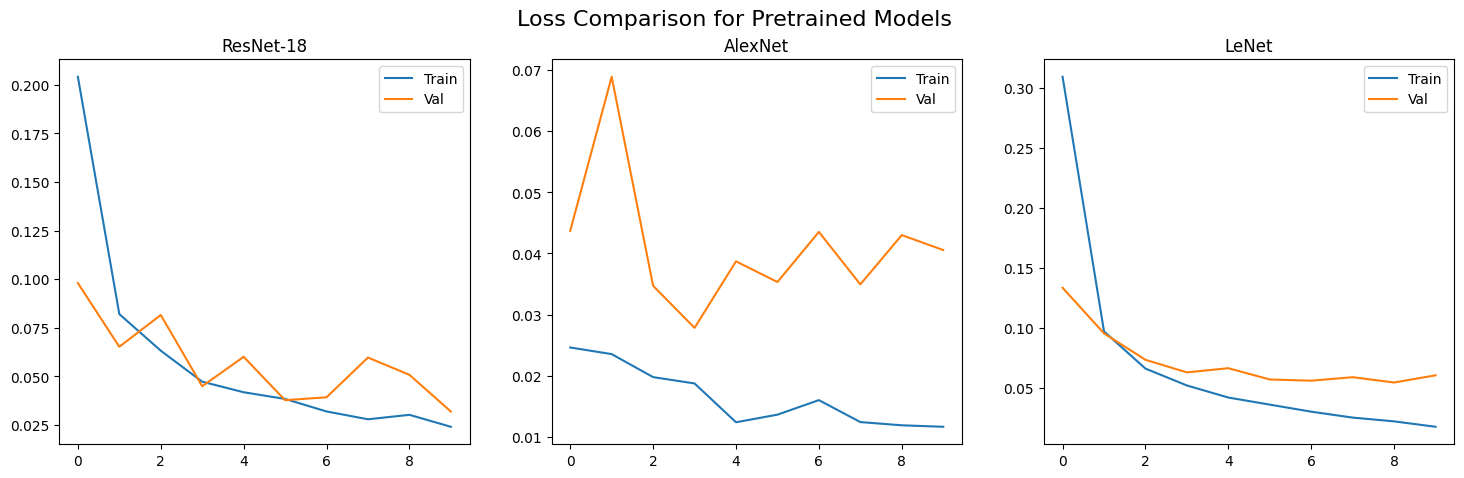

In [ ]:
# Accuracy Comparision
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Accuracy Comparison for Pretrained Models", fontsize=16)

axs[0].plot(resnet_tr_acc, label='Train')
axs[0].plot(resnet_val_acc, label='Val')
axs[0].set_title("ResNet-18")
axs[0].legend()

axs[1].plot(alexnet_tr_acc, label='Train')
axs[1].plot(alexnet_val_acc, label='Val')
axs[1].set_title("AlexNet")
axs[1].legend()

axs[2].plot(lenet_tr_acc, label='Train')
axs[2].plot(lenet_val_acc, label='Val')
axs[2].set_title("LeNet")
axs[2].legend()

plt.show()


# Loss comparision
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Loss Comparison for Pretrained Models", fontsize=16)

axs[0].plot(resnet_tr_loss, label='Train')
axs[0].plot(resnet_val_loss, label='Val')
axs[0].set_title("ResNet-18")
axs[0].legend()

axs[1].plot(alexnet_tr_loss, label='Train')
axs[1].plot(alexnet_val_loss, label='Val')
axs[1].set_title("AlexNet")
axs[1].legend()

axs[2].plot(lenet_tr_loss, label='Train')
axs[2].plot(lenet_val_loss, label='Val')
axs[2].set_title("LeNet")
axs[2].legend()

plt.show()



Predict the Output with Pretrained Model

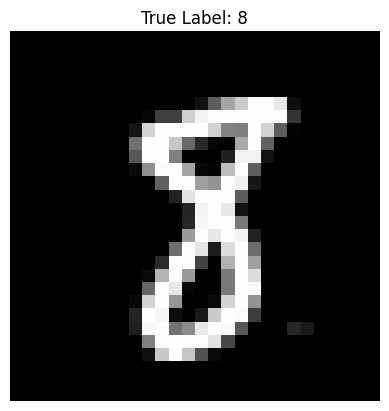

Predicted Label: 8


In [ ]:
predict_test_image(lenet_model, test_dataset)       #resnet18_model, alexnet_model, lenet_model

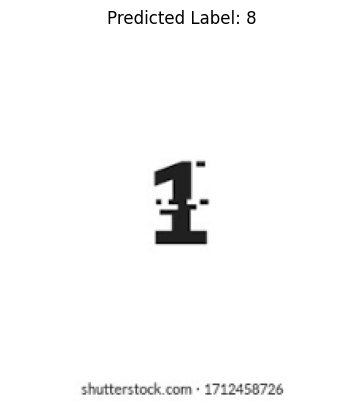

In [ ]:
predict_custom_image(lenet_model, '/content/drive/MyDrive/DeepLearning/test_image_mnist_1.png')   #resnet18_model, alexnet_model, lenet_model

In [ ]:
!git config --global user.name "Shreya7Code"
!git config --global user.email "thshreya7code@gmail.com"


In [ ]:
!git clone https://github.com/shreya7code/CNN_Models_MNSIT.git


Cloning into 'CNN_Models_MNSIT'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


In [5]:
# import shutil

# shutil.copy('/content/drive/MyDrive/Colab Notebooks/deeplearning_assignment2.ipynb', '/content/CNN_Models_MNSIT/')
